In [21]:
#importing some models. Going to use tensorflow for modelling
#nltk contains list of stopwords to remove
#also import seaborn for plotting



import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import nltk
import re
import tensorflow_hub as hub





#some useful packages from natural language toolkit
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from tqdm import tqdm


from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.math import confusion_matrix

#this is a trick to make the plots look better in dark mode
#plt.style.use('dark_background')
#sns.set_palette('bright')



%matplotlib inline

In [22]:
#list of contractions 
#https://gist.github.com/nealrs/96342d8231b75cf4bb82/revisions with some changes


import re
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "i would",
  "i'd've": "i would have",
  "i'll": "i will",
  "i'll've": "i will have",
  "i'm": "i am",
  "i've": "i have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

def expandContractions(text,cList=cList):
    for word, replacement in cList.items():
        text = text.replace(word.lower(), replacement)
    return text


In [23]:
#import datasets. Also make seperate datasets for disaster and no disaster for EDA


#use when running on cloud to fetch datasets
#!wget 'https://raw.githubusercontent.com/LRozeboom/nlp_disaster/master/test.csv'
#!wget 'https://raw.githubusercontent.com/LRozeboom/nlp_disaster/master/train.csv'

df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

disaster=df_train[df_train['target']==1]
nodisaster=df_train[df_train['target']==0]
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [24]:
#look at some differences between disaster and nodisaster tweets
#first calculate some text properties for plotting


def avg_wordlength(sentence):
    words = sentence.split()
    average = sum(len(word) for word in words) / len(words)
    return average

def num_chars(sentence):
    return len(sentence)

def word_count(sentence):
    return len(str(sentence).split())

def hashtag_count(sentence):
    return sentence.count('#')

def at_count(sentence):
    return sentence.count('@')


#apply these functions to the dataframes for distaster and nodisaster

disaster['avg_wordlen']=disaster['text'].apply(lambda x: avg_wordlength(x))
nodisaster['avg_wordlen']=nodisaster['text'].apply(lambda x: avg_wordlength(x))

disaster['num_chars']=disaster['text'].apply(lambda x: num_chars(x))
nodisaster['num_chars']=nodisaster['text'].apply(lambda x: num_chars(x))

disaster['word_count']=disaster['text'].apply(lambda x: word_count(x))
nodisaster['word_count']=nodisaster['text'].apply(lambda x: word_count(x))

disaster['hashtag_count']=disaster['text'].apply(lambda x: hashtag_count(x))
nodisaster['hashtag_count']=nodisaster['text'].apply(lambda x: hashtag_count(x))

disaster['at_count']=disaster['text'].apply(lambda x: at_count(x))
nodisaster['at_count']=nodisaster['text'].apply(lambda x: at_count(x))

disaster.head()






/tmp/ipykernel_16276/2062797363.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disaster['avg_wordlen']=disaster['text'].apply(lambda x: avg_wordlength(x))
/tmp/ipykernel_16276/2062797363.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodisaster['avg_wordlen']=nodisaster['text'].apply(lambda x: avg_wordlength(x))
/tmp/ipykernel_16276/2062797363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,id,keyword,location,text,target,avg_wordlen,num_chars,word_count,hashtag_count,at_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,4.384615,69,13,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,4.571429,38,7,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,5.090909,133,22,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,7.125000,65,8,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,4.500000,88,16,2,0


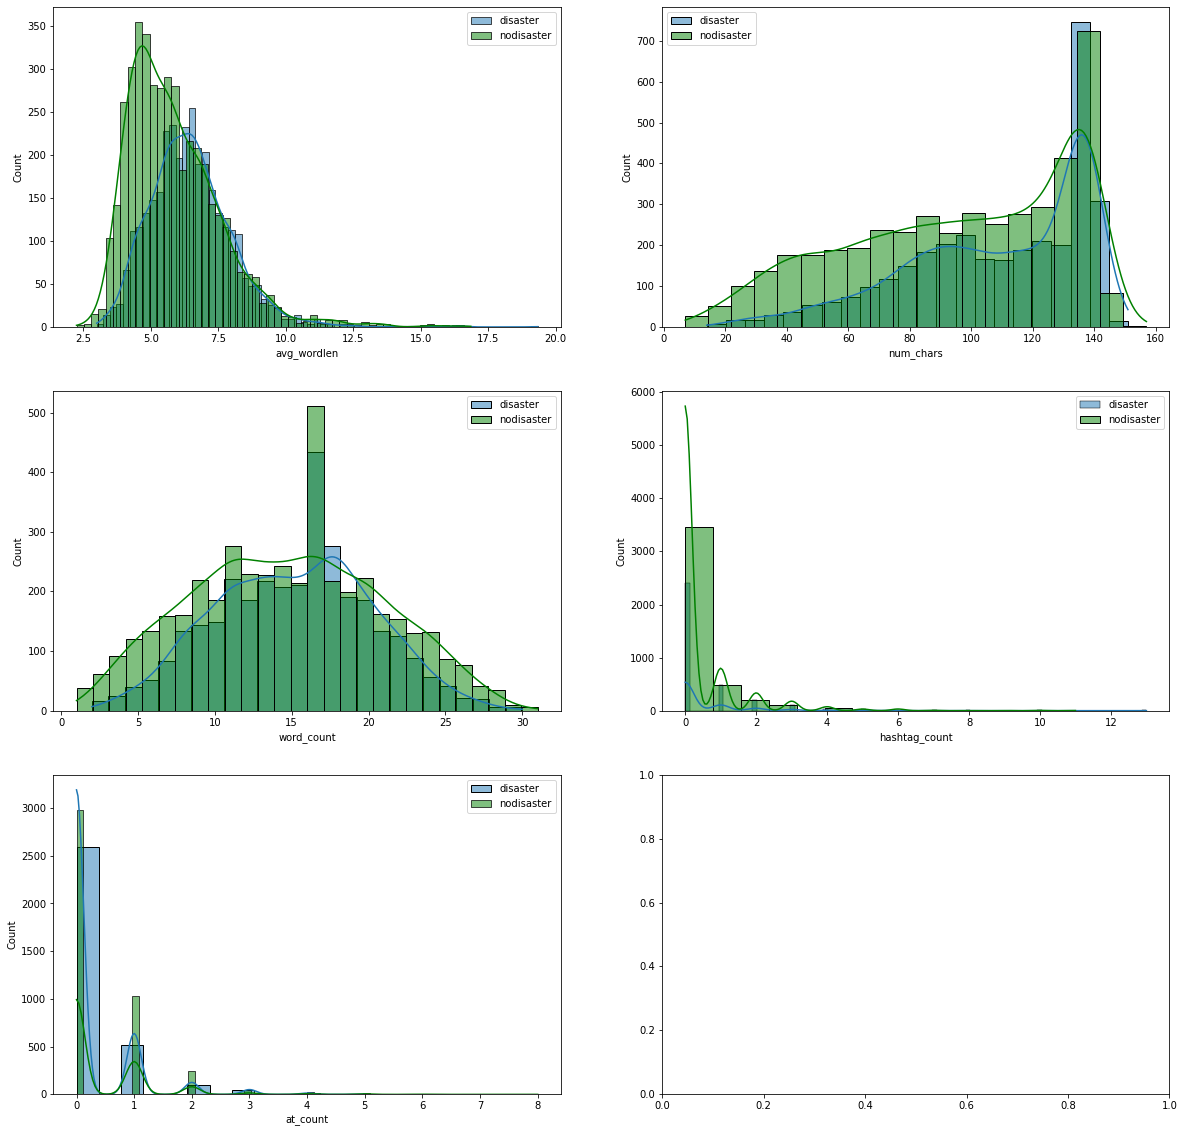

In [25]:
#now compare these values for disaster and non-disaster tweets


fig,axes=plt.subplots(3,2,figsize=(20,20))

sns.histplot(disaster['avg_wordlen'] ,label='disaster',ax=axes[0,0],kde=True)
sns.histplot(nodisaster['avg_wordlen'],label='nodisaster',ax=axes[0,0],kde=True,color='green')
axes[0,0].legend()

sns.histplot(disaster['num_chars'] ,label='disaster',ax=axes[0,1],kde=True)
sns.histplot(nodisaster['num_chars'],label='nodisaster',ax=axes[0,1],kde=True,color='green')
axes[0,1].legend()

sns.histplot(disaster['word_count'] ,label='disaster',ax=axes[1,0],kde=True)
sns.histplot(nodisaster['word_count'],label='nodisaster',ax=axes[1,0],kde=True,color='green')
axes[1,0].legend()


sns.histplot(disaster['hashtag_count'] ,label='disaster',ax=axes[1,1],kde=True)
sns.histplot(nodisaster['hashtag_count'],label='nodisaster',ax=axes[1,1],kde=True,color='green')
axes[1,1].legend()

sns.histplot(disaster['at_count'] ,label='disaster',ax=axes[2,0],kde=True)
sns.histplot(nodisaster['at_count'],label='nodisaster',ax=axes[2,0],kde=True,color='green')
axes[2,0].legend()

In [26]:
#look at different keywords, display average target value

df_train.groupby('keyword').mean().head(5)


,id,target
keyword,,
ablaze,70.388889,0.361111
accident,121.800000,0.685714
aftershock,171.323529,0.000000
airplane%20accident,220.142857,0.857143
ambulance,269.052632,0.526316


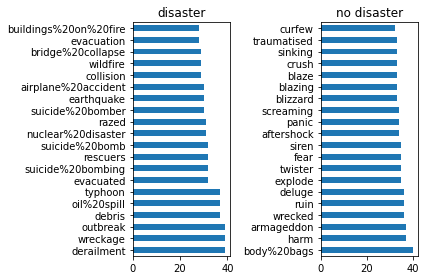

In [27]:
#keyword distribution for disaster and non-disaster
disaster_keywordcounts=disaster['keyword'].value_counts()
nodisaster_keywordcounts=nodisaster['keyword'].value_counts()

#barplot of most frequent keywords for disaster and no-disaster
fig,ax=plt.subplots(1,2)
disaster_keywordcounts[:20].plot.barh(ax=ax[0])
ax[0].set_title('disaster')
nodisaster_keywordcounts[:20].plot.barh(ax=ax[1])
ax[1].set_title('no disaster')

fig.tight_layout()
#plt.figure()
#sns.distplot(disaster_keywordcounts)
#sns.distplot(nodisaster_keywordcounts)


In [28]:
#look how many empty columns we have
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [29]:
#count number of disasters and nodisasters in training set
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [30]:
#put everything to lower case, remove #, @ and ' from tweets.
#found out this was built into tokenizer


df_train['text_clean'] = df_train['text'].apply(lambda x: x.lower())
# df_train['text_clean'] = df_train['text_clean'].str.replace('#','')
# df_train['text_clean'] = df_train['text_clean'].str.replace('@','')

# df_train['text_clean'] = df_train['text_clean'].str.replace('?','')
# df_train['text_clean'] = df_train['text_clean'].str.replace('!','')
# df_train['text_clean'] = df_train['text_clean'].str.replace('=>','')
# df_train['text_clean'] = df_train['text_clean'].str.replace('-','')
# df_train['text_clean'] = df_train['text_clean'].str.replace(',','')
# df_train['text_clean'] = df_train['text_clean'].str.replace(':','')
# df_train['text_clean'] = df_train['text_clean'].str.replace(';','')
# df_train['text_clean'] = df_train['text_clean'].str.replace(')','')
# df_train['text_clean'] = df_train['text_clean'].str.replace('(','')

#removing some nonsense from dictionary. There are many more, but here are the most common ones

df_train['text_clean'] = df_train['text_clean'].str.replace('\x89û','')
df_train['text_clean'] = df_train['text_clean'].str.replace('\x89ûò','')
df_train['text_clean'] = df_train['text_clean'].str.replace('\x89ûó','')
df_train['text_clean'] = df_train['text_clean'].str.replace('\x89ûï','')



#remove numbers
df_train['text_clean'] = df_train['text_clean'].str.replace('\d+', '')
    

#remove urls from tweets
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

df_train['text_clean']=df_train['text_clean'].apply(lambda x: remove_url(x))


#expand some common contractions using custom code

df_train['text_clean']=df_train['text_clean'].apply(lambda x: expandContractions(x))


#removing quotation marks as they are not removed by the tensorflow tokenizer by default
df_train['text_clean'] = df_train['text_clean'].str.replace('\'','')

df_train.head(30)

/tmp/ipykernel_16276/4043398922.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train['text_clean'] = df_train['text_clean'].str.replace('\d+', '')


,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,", people receive #wildfires evacuation orders ..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,#rockyfire update => california hwy. closed i...
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,#flood #disaster heavy rain causes flash flood...
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,i am on top of the hill and i can see a fire i...
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,there is an emergency evacuation happening now...
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,i am afraid that the tornado is coming to our ...


In [31]:
#train/validation split

xtrain, xval, ytrain, yval=train_test_split(df_train['text_clean'],df_train['target'])


#remove stopwords from train set, this will make these words out of vocabulary
#create list of stopwords to remove

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

xtrain = [' '.join([y for y in x.split() if y not in stop_words]) for x in xtrain]
xtrain[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['watertown gazette owner charged wreck',
 '@klarajoelsson well seen now! bummer. heat wave tho... c!! would prefer rain... :p',
 'beautiful disaster',
 'many thx share comment alex lightman - evidence take take your...',
 'check malaysia confirms plane wreckage flight mh',
 'meek mill responds drakeªs ovo fest set wedgie threat',
 'm. [: utc]?km nnw lake henshaw california.',
 'pandemonium aba woman delivers baby without face (photos) -',
 'ruin life to.',
 'want rainstorm please']

In [32]:
#defining some variables, making it easier to tune them later

vocab_size = 10000
embedding_dim = 50   #using glove 50d
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

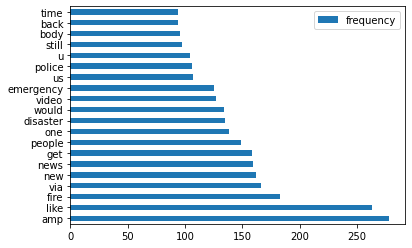

In [33]:
#create tokenizer object and fit on text
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)


tokenizer.fit_on_texts(xtrain)
wordcounts=tokenizer.word_counts
word_index = tokenizer.word_index


#word count to dataframe for visualization
df=pd.DataFrame(wordcounts.values(),index=wordcounts.keys(),columns=['frequency'])


sorteddf=df.sort_values(by=['frequency'],ascending=False)


sorteddf[0:20].plot.barh()

In [34]:
embeddings_index = {}
f = open('glove.6B.50d.txt')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:],dtype = 'float32')
    embeddings_index[word] = coefs
    
    

400000it [00:06, 59921.99it/s]


In [35]:
embedding_matrix = np.zeros((len(word_index)+1,embedding_dim))
for word,i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_matrix[:5]

100%|██████████| 13973/13973 [00:00<00:00, 628985.80it/s]


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00

In [36]:
#ceate sequences and pad sequences
train_seq=tokenizer.texts_to_sequences(xtrain)
train_padded=pad_sequences(train_seq,maxlen=max_length, padding=padding_type, truncating=trunc_type)

val_seq=tokenizer.texts_to_sequences(xval)
val_padded=pad_sequences(val_seq,maxlen=max_length, padding=padding_type, truncating=trunc_type)
val_padded[3]


array([4814, 1813,  985,  101, 1658,  139,  130,  833,   61,   54, 2673,
       1622,   64,  105, 1113,  477,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

2022-02-04 08:50:45.063987: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-04 08:50:52.630463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7429 MB memory:  -> device: 0, name: Tesla M60, pci bus id: 0001:00:00.0, compute capability: 5.2


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           698700    
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         58880     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4

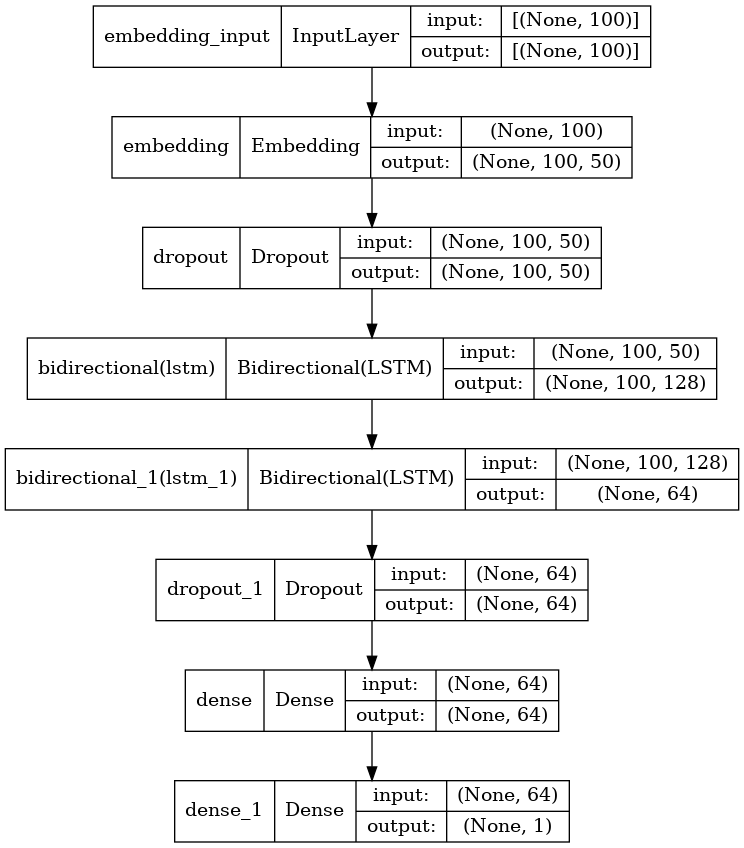

In [37]:
#bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)
#bert_layer=hub.KerasLayer(module_url, trainable=True, name='BERT')
#bert_preprocessing=hub.KerasLayer(tfhub_handle_preprocess, trainable=True, name='vectorizing')



model=tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1,embedding_dim,weights = [embedding_matrix],input_length=max_length,trainable = False), #must not be trainable as we use pretrained Glove embeddings
    #tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length,mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])


model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)


Epoch 1/20
179/179 - 26s - loss: 0.5329 - accuracy: 0.7478 - val_loss: 0.4712 - val_accuracy: 0.7868 - 26s/epoch - 148ms/step
Epoch 2/20
179/179 - 4s - loss: 0.4865 - accuracy: 0.7751 - val_loss: 0.4552 - val_accuracy: 0.7936 - 4s/epoch - 23ms/step
Epoch 3/20
179/179 - 4s - loss: 0.4801 - accuracy: 0.7747 - val_loss: 0.4642 - val_accuracy: 0.7967 - 4s/epoch - 23ms/step
Epoch 4/20
179/179 - 4s - loss: 0.4696 - accuracy: 0.7870 - val_loss: 0.4548 - val_accuracy: 0.7883 - 4s/epoch - 23ms/step
Epoch 5/20
179/179 - 4s - loss: 0.4664 - accuracy: 0.7882 - val_loss: 0.4418 - val_accuracy: 0.7978 - 4s/epoch - 23ms/step
Epoch 6/20
179/179 - 4s - loss: 0.4646 - accuracy: 0.7888 - val_loss: 0.4559 - val_accuracy: 0.7852 - 4s/epoch - 23ms/step
Epoch 7/20
179/179 - 4s - loss: 0.4572 - accuracy: 0.7893 - val_loss: 0.4444 - val_accuracy: 0.7925 - 4s/epoch - 23ms/step
Epoch 8/20
179/179 - 4s - loss: 0.4421 - accuracy: 0.8000 - val_loss: 0.4391 - val_accuracy: 0.8025 - 4s/epoch - 23ms/step
Epoch 9/20
17

2022-02-04 08:51:07.742640: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


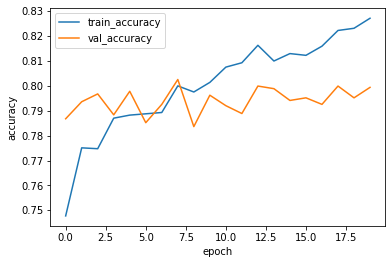

tf.Tensor(
[[980  92]
 [290 542]], shape=(2, 2), dtype=int32)


In [38]:
num_epochs = 20
history = model.fit(train_padded, ytrain, epochs=num_epochs, validation_data=(val_padded, yval), verbose=2)

plt.plot(history.history['accuracy'],label='train_accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

yhat=model.predict(val_padded)
ypred=[1 if val>0.5 else 0 for val in yhat ]
print(confusion_matrix(yval,ypred))

In [39]:
#now apply the moddel to predict wether a sentence is about a disaster


df_test['text_clean'] = df_test['text'].apply(lambda x: x.lower())
# df_test['text_clean'] = df_test['text_clean'].str.replace('#','')
# df_test['text_clean'] = df_test['text_clean'].str.replace('@','')
# df_test['text_clean'] = df_test['text_clean'].str.replace('\d+', '')
# df_test['text_clean'] = df_test['text_clean'].str.replace('\'','')
# df_test['text_clean'] = df_test['text_clean'].str.replace('?','')
# df_test['text_clean'] = df_test['text_clean'].str.replace('!','')
# df_test['text_clean'] = df_test['text_clean'].str.replace('=>','')
# df_test['text_clean'] = df_test['text_clean'].str.replace('-','')
# df_test['text_clean'] = df_test['text_clean'].str.replace(',','')
# df_test['text_clean'] = df_test['text_clean'].str.replace(':','')
# df_test['text_clean'] = df_test['text_clean'].str.replace(';','')
# df_test['text_clean'] = df_test['text_clean'].str.replace(')','')
# df_test['text_clean'] = df_test['text_clean'].str.replace('(','')


df_test['text_clean']=df_test['text_clean'].apply(lambda x: remove_url(x))
df_test['text_clean']=df_test['text_clean'].apply(lambda x: expandContractions(x))
df_test['text_clean'] = df_test['text_clean'].str.replace('\'','')




sentences=df_test['text_clean']

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

predictions=model.predict(padded)

In [40]:
df_test['prob_disaster']=predictions

df_test['target']=df_test['prob_disaster'].apply(lambda x: 1 if x>0.5 else 0)

df_output=df_test[['id','target']]

In [41]:
df_output.to_csv('output.csv',index=False)

In [42]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]